This notebook trains a Vector Autoregressive Model for conditional forecasting.

The data transformations and preparation are used from the Data-Transformations notebook.

## Import Packages

In [1]:
import gresearch_crypto

from datetime import datetime
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gc
import numpy as np
import pandas as pd

## Declare variables

In [2]:
train_filepath = '/kaggle/input/g-research-crypto-forecasting/train.csv'
asset_details_filepath = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

## Declare Cleaning Functions

In [3]:
def clean_dates(df):
    '''
    Function to clean timestamps of an individual coin 
    by the earliest and latest timestamps observed for that coin.
    Also fills in missing values by the method chosen for the interpolate function.
    
    Inputs: 
        df (pd.DataFrame.GroupBy object) :
            Grouped Dataframe by unique coins. All timestamps must be
            in intervals of 60 seconds.

    Outputs:
        constant_dates_df (pd.DataFrame) :
            Dataframe with timestamps and filled missing values.
    '''
    
    df = df.copy()
    
    dates = range(min(df["timestamp"]), max(df["timestamp"]), 60)
    
    df.set_index("timestamp", inplace = True)
    
    df = df.reindex(dates)
    
    # replace the 9 infinite values with NaN, which are interpolated in the next line
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    
    # don't fill missing values at end of dataset, where they do not
    # have ending observations to interpolate with
    df.interpolate(method = "linear", inplace = True, limit_area = "inside")
    
    return df
    
def standardize_data(df):
    '''
    Function to standardize data by creating rows for every timestamp
    and subsetting to only consider when all coins had their first observation made.
    
    Inputs:
        df (pd.DataFrame) :
            Time series data to be standardized
            
    Outputs:
        standard_df (pd.DataFrame) :
            Time series data now standardized
    '''
    
    # deep copy to not alter the original
    df = df.copy()
    
    # fill missing rows / values between coin's start and stop date
    # Note: Missing rows beyond an individual coin's start / stop date are not created,
    # only those between are filled in
    standard_df = df.groupby("Asset_ID").apply(clean_dates).reset_index(level = 0, drop = True)
    
    # reset twice so timestamp is only a column and not also index, 
    # this makes each entry have a unique index
    standard_df = standard_df.reset_index()
    
    # get the earliest timestamp for each coin, then get the latest timestamp out of those.
    # this shows when the latest coin was introduced, after which there are observations for
    # all coins
    first_timestamp = max(standard_df.groupby("Asset_ID")["timestamp"].min())
    
    # subset to only consider the time period where observations existed for all coins
    standard_df = standard_df.loc[standard_df["timestamp"] >= first_timestamp]
    
    # drop ending rows with missing values
    standard_df.dropna(inplace = True)
    
    # convert to int to better reflect nature of data
    standard_df["Count"] = standard_df["Count"].astype("int")
    standard_df["Asset_ID"] = standard_df["Asset_ID"].astype("int")
    
    return standard_df

def df_long_to_wide(df, group_column, cols_to_keep, time_col):
    '''
    Function to transform data from long to wide format.
    
    Assumes passed DataFrame is in long format, where each row corresponds to
    a unique observation in cross section and in time (i.e. the values of a specific
    coin at a specific time)
    
    Returns a formatted DataFrame in wide format, where each row corresponds only 
    to a unique time. 
    
    Inputs:
        df (pd.DataFrame) :
            Time series data in long format
            
        group_column (str) :
            String of the column to be grouped by, representing
            the cross sectional identifier of the data 
            (e.g. identifier for which coin out of 14 
            cryptocurrencies the row represents)
            
        cols_to_keep (list of strs) :
            List of strings, where each string represents a column
            to keep and include in the new wide dataframe. Each column
            will be repeated for each group (e.g. for two groups and
            three columns, each row will have six appended columns
            in the wide df) 
            
        time_col (str) :
            String of the column that contains time information
            
    Outputs:
        wide_df (pd.DataFrame) :
            Time series data in wide format
    '''
    
    df = df.copy()

    # extract only the unique times and sort them in a new dataframe
    unique_times = df.loc[:, time_col].unique()
    wide_df = pd.DataFrame(data = {time_col : sorted(unique_times)})

    grouped_df = df.groupby(group_column)
    group_list = [grouped_df.get_group(x).copy() for x in grouped_df.groups]

    for group in group_list:
        
        # create new unique names for the cols indicating which cross section
        # they belong to
        new_col_names = [name + "_" + str(group.loc[:, group_column].iloc[0]) 
                         for name in cols_to_keep]

        rename_dict = {col : new_col for col in cols_to_keep for new_col in new_col_names}
        group.rename(columns = rename_dict, inplace = True, errors = "raise")

        # add columns to the wide df
        wide_df = wide_df.merge(group.loc[:, new_col_names + [time_col]], on = time_col,
                               how = "left")

        gc.collect()

    return wide_df

## Import and Clean Data

In [4]:
df = pd.read_csv(train_filepath)
asset_details_df = pd.read_csv(asset_details_filepath)

standard_df = standardize_data(df)
standard_df = df_long_to_wide(standard_df, "Asset_ID", ["Target"], "timestamp")

latest_timestamp = standard_df.loc[:, "timestamp"].max()

# 60 seconds per minute, 60 minutes per hour, 24 hours per day, ~30 days per month,
# for 3 months
cutoff_timestamp = 60*60*24*30*3

standard_train_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp]
standard_test_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp]

standard_train_df.set_index("timestamp", inplace = True)
standard_test_df.set_index("timestamp", inplace = True)

In [5]:
del df
gc.collect()

60

In [6]:
standard_train_df

,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13
timestamp,,,,,,,,,,,,,,
1555079640,-0.001787,-0.001882,-0.003690,-0.002951,0.006126,-0.002293,-0.001438,-0.000829,0.027632,0.002480,-0.019710,0.011912,-0.001524,-0.002559
1555079700,-0.001602,-0.000731,-0.001639,-0.002924,0.007576,-0.001225,-0.001777,0.001051,0.000000,0.003282,-0.019708,0.015584,-0.001226,-0.004204
1555079760,-0.000504,-0.001341,-0.002862,-0.003826,0.008655,-0.002608,-0.001946,-0.007041,0.026926,0.001506,-0.019706,0.014726,-0.002385,0.000026
1555079820,0.000566,-0.001508,-0.000222,-0.002333,0.009373,-0.007047,-0.001211,-0.000373,0.002067,0.000960,-0.019704,0.017296,-0.003115,-0.000975
1555079880,0.000000,-0.001657,-0.005420,-0.002824,0.009369,-0.003066,-0.001697,-0.000014,0.027723,0.000273,-0.019702,0.017488,-0.002968,-0.004186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624405140,0.003837,-0.001987,0.001144,0.010975,-0.001471,-0.003792,0.000044,0.000378,0.009319,-0.001514,0.002873,-0.013900,0.001576,-0.000036
1624405200,0.005019,-0.002226,0.003616,0.010209,-0.002754,-0.002935,0.000567,-0.000435,0.009596,0.001226,0.005023,-0.012979,0.002292,-0.000741
1624405260,0.005909,-0.001798,0.001411,0.007625,-0.001629,-0.001701,0.001436,-0.001410,0.014052,0.001162,0.005137,-0.012925,0.003187,0.000537


In [7]:
standard_test_df

,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13
timestamp,,,,,,,,,,,,,,
1624405440,0.007666,-0.001197,0.005524,0.005235,-0.004115,-0.002951,0.002168,-0.002057,0.010136,0.000865,0.004384,-0.009090,0.001459,0.002707
1624405500,0.013220,-0.001430,0.007835,0.002967,-0.003292,-0.003119,0.001220,0.004599,0.008768,-0.002387,0.011461,-0.007924,0.002208,0.001617
1624405560,0.003928,-0.001494,0.005463,0.003012,0.000253,-0.001243,-0.001406,0.001828,-0.001801,-0.002253,0.003572,-0.006417,0.003931,0.001282
1624405620,0.002770,-0.001203,0.003554,0.002526,-0.001437,0.000759,-0.000607,-0.000611,-0.006199,0.001865,0.000289,-0.005295,0.000273,0.001187
1624405680,-0.003693,-0.000965,0.003438,0.000898,-0.000081,0.001166,0.001265,-0.003541,-0.009373,0.002602,-0.005821,-0.006012,-0.000477,0.001080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632181200,0.002325,0.002084,0.002919,-0.003660,-0.001142,0.000941,-0.001309,0.000468,0.000664,0.002442,0.001008,-0.001876,-0.000743,0.000199
1632181260,0.000995,0.003246,-0.001943,-0.000785,-0.001968,0.000416,-0.000736,-0.000676,-0.002656,0.000665,-0.001030,-0.004123,-0.000860,-0.003477
1632181320,0.001499,0.003108,-0.000911,-0.001108,-0.000885,-0.000383,-0.000491,-0.001177,-0.003244,-0.000453,0.000006,-0.003768,-0.001822,-0.002437


In [8]:
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Define and Train Model

In [9]:
model = VAR(standard_train_df)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [10]:
fit_results = model.fit(trend = "n")

fit_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 26, Mar, 2022
Time:                     19:37:03
--------------------------------------------------------------------
No. of Equations:         14.0000    BIC:                   -172.316
Nobs:                 1.15543e+06    HQIC:                  -172.317
Log likelihood:       7.65979e+07    FPE:                1.45668e-75
AIC:                     -172.318    Det(Omega_mle):     1.45644e-75
--------------------------------------------------------------------
Results for equation Target_0
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
L1.Target_0          0.904340         0.000407         2220.823           0.000
L1.Target_1          0.005499         0.000846            6.502           0.000
L1.Target_2         -0.003166         0.000485           -6.5

In [11]:
# print in easier to read format
print("Absolute correlation:")
print('    '.join([str(i) for i in range(14)]))
print('\n'.join([' '.join(['{:.2f}'.format(abs(item)) for item in row]) for row in fit_results.resid_corr]))

Absolute correlation:
0    1    2    3    4    5    6    7    8    9    10    11    12    13
1.00 0.01 0.00 0.04 0.07 0.02 0.02 0.22 0.00 0.00 0.03 0.03 0.01 0.02
0.01 1.00 0.10 0.07 0.13 0.03 0.20 0.27 0.05 0.09 0.00 0.00 0.03 0.03
0.00 0.10 1.00 0.03 0.13 0.12 0.09 0.15 0.05 0.15 0.02 0.03 0.01 0.05
0.04 0.07 0.03 1.00 0.10 0.03 0.05 0.19 0.01 0.04 0.02 0.01 0.09 0.02
0.07 0.13 0.13 0.10 1.00 0.11 0.16 0.02 0.01 0.14 0.07 0.03 0.10 0.09
0.02 0.03 0.12 0.03 0.11 1.00 0.05 0.14 0.04 0.09 0.02 0.02 0.02 0.05
0.02 0.20 0.09 0.05 0.16 0.05 1.00 0.30 0.05 0.09 0.05 0.04 0.03 0.03
0.22 0.27 0.15 0.19 0.02 0.14 0.30 1.00 0.00 0.17 0.15 0.00 0.12 0.16
0.00 0.05 0.05 0.01 0.01 0.04 0.05 0.00 1.00 0.05 0.01 0.10 0.00 0.02
0.00 0.09 0.15 0.04 0.14 0.09 0.09 0.17 0.05 1.00 0.02 0.03 0.00 0.02
0.03 0.00 0.02 0.02 0.07 0.02 0.05 0.15 0.01 0.02 1.00 0.02 0.03 0.04
0.03 0.00 0.03 0.01 0.03 0.02 0.04 0.00 0.10 0.03 0.02 1.00 0.02 0.02
0.01 0.03 0.01 0.09 0.10 0.02 0.03 0.12 0.00 0.00 0.03 0.02 1.00 0.

In [12]:
print( "Percentage of non-significant coefficients: " +
    str(round(100*sum(sum(fit_results.pvalues.values > 0.05)) / fit_results.pvalues.values.size)) +
     "%")

Percentage of non-significant coefficients: 9%


Shown above, most coefficients are significant in the VAR model. This is impressive, as there are 14 * 14 = 196 coefficients in total. This comes from 14 equations with 14 coefficients for each variable.

There is also some correlation among the residuals, where certain entries have a correlation as high as 0.30 

The fitted values can be overlaid with the original data

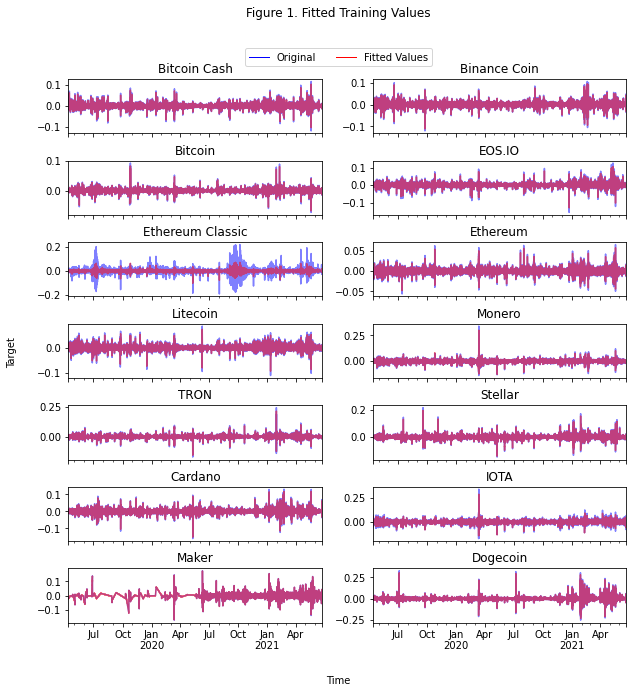

In [13]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp].copy()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)
temp_fit = fit_results.fittedvalues.copy()
temp_fit["timestamp"] = temp_fit.index
temp_fit.loc[:, "datetime"] = pd.to_datetime(temp_fit.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    temp_fit.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 1. Fitted Training Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Fitted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("train.png")    
plt.show()

In [14]:
del temp_df
del temp_fit
gc.collect()

81

## Make Forecasts and Evaluate

In [15]:
forecasts = fit_results.forecast(y = standard_train_df.iloc[[-1]].values, steps = len(standard_test_df))

In [16]:
forecasts

array([[ 1.41917582e-002, -2.56246510e-003,  3.23033947e-003, ...,
        -6.82575004e-003,  4.21108101e-003,  1.89995366e-003],
       [ 1.29557236e-002, -2.35108874e-003,  2.92872108e-003, ...,
        -4.94180646e-003,  4.06829935e-003,  1.85653365e-003],
       [ 1.18399026e-002, -2.14775953e-003,  2.66512996e-003, ...,
        -3.45984773e-003,  3.93027565e-003,  1.81881798e-003],
       ...,
       [ 2.47032823e-323,  2.47032823e-323,  1.97626258e-323, ...,
         1.48219694e-323, -1.97626258e-323,  1.97626258e-323],
       [ 2.47032823e-323,  2.47032823e-323,  1.97626258e-323, ...,
         1.48219694e-323, -1.97626258e-323,  1.97626258e-323],
       [ 2.47032823e-323,  2.47032823e-323,  1.97626258e-323, ...,
         1.48219694e-323, -1.97626258e-323,  1.97626258e-323]])

In [17]:
forecast_df = pd.DataFrame(data = forecasts, columns = standard_test_df.columns)

forecast_df

,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13
0,1.419176e-02,-2.562465e-03,3.230339e-03,5.682730e-03,-6.504637e-03,1.016281e-04,1.555263e-03,0.002580,1.406268e-02,2.088273e-03,1.351497e-02,-6.825750e-03,4.211081e-03,1.899954e-03
1,1.295572e-02,-2.351089e-03,2.928721e-03,5.347521e-03,-5.859949e-03,2.654798e-04,1.304522e-03,0.003303,1.115934e-02,1.805909e-03,1.340099e-02,-4.941806e-03,4.068299e-03,1.856534e-03
2,1.183990e-02,-2.147760e-03,2.665130e-03,5.041784e-03,-5.272673e-03,3.950549e-04,1.104623e-03,0.003374,9.048728e-03,1.576548e-03,1.329956e-02,-3.459848e-03,3.930276e-03,1.818818e-03
3,1.082119e-02,-1.960617e-03,2.426011e-03,4.751652e-03,-4.737636e-03,4.878176e-04,9.358878e-04,0.003248,7.504523e-03,1.381390e-03,1.319824e-02,-2.295258e-03,3.788836e-03,1.775302e-03
4,9.888765e-03,-1.790492e-03,2.207047e-03,4.474281e-03,-4.250016e-03,5.494574e-04,7.907237e-04,0.003070,6.365377e-03,1.212548e-03,1.309399e-02,-1.381609e-03,3.643937e-03,1.724865e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129596,2.470328e-323,2.470328e-323,1.976263e-323,-1.976263e-323,3.458460e-323,1.482197e-323,1.482197e-323,0.000000,9.881313e-324,-1.482197e-323,2.371515e-322,1.482197e-323,-1.976263e-323,1.976263e-323
129597,2.470328e-323,2.470328e-323,1.976263e-323,-1.976263e-323,3.458460e-323,1.482197e-323,1.482197e-323,0.000000,9.881313e-324,-1.482197e-323,2.371515e-322,1.482197e-323,-1.976263e-323,1.976263e-323
129598,2.470328e-323,2.470328e-323,1.976263e-323,-1.976263e-323,3.458460e-323,1.482197e-323,1.482197e-323,0.000000,9.881313e-324,-1.482197e-323,2.371515e-322,1.482197e-323,-1.976263e-323,1.976263e-323
129599,2.470328e-323,2.470328e-323,1.976263e-323,-1.976263e-323,3.458460e-323,1.482197e-323,1.482197e-323,0.000000,9.881313e-324,-1.482197e-323,2.371515e-322,1.482197e-323,-1.976263e-323,1.976263e-323


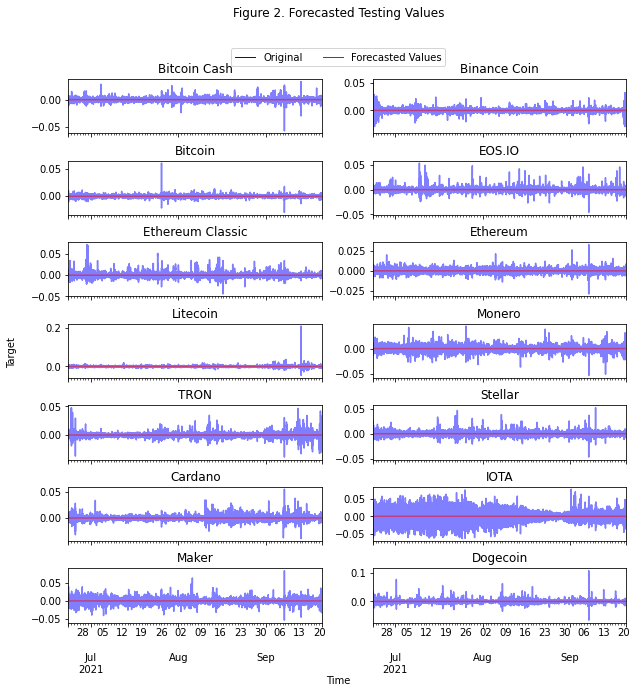

In [18]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp].copy()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

temp_fit = forecast_df.copy()
temp_fit.loc[:, "datetime"] = temp_df.loc[:, "datetime"].values.copy()

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    temp_fit.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 2. Forecasted Testing Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Forecasted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("test.png")    
plt.show()

In [19]:
del temp_df
del temp_fit
gc.collect()

58729

In [20]:
fit_results.save("var_results.pickle")